# Packages

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesflow as bf
import keras
from swift import toyswift

# Explore Data

In [ ]:
df=pd.read_csv("fixseqin_PB2expVP10.dat",
     delimiter="\t",
     names=["sentID", "wordID", "duration"],
     usecols=[0, 1, 3])

FileNotFoundError: [Errno 2] No such file or directory: 'fixseqin_PB2expVP10.dat'

In [ ]:
df.head()

,sentID,wordID,duration
0,1,1,183
1,1,3,165
2,1,3,115
3,1,4,210
4,1,6,266


In [ ]:
import pandas as pd

corpus=pd.read_csv("Rcorpus_PB2.dat", delimiter="\t", 
                   #usecols=range(5)
                   )
corpus.head()

,sentID,nw,wordID,length,freq,code
0,1,11,1,3,112.096683,9
1,1,11,2,3,532.671797,9
2,1,11,3,10,3.237331,9
3,1,11,4,4,6557.467940,9
4,1,11,5,3,20527.116504,9


## Plots

In [12]:
sim = toyswift(nu=0.3, r=10, mt=200, eta=-3, NW=10, return_activation_values=True)
nu=0.3; r=10; mt=200 ; eta=-3; NW=10

In [ ]:
sim["activations"].head()
print(sim["trajectory"])

      Time  Fixation    Duration  Observed
0      0.0       1.0  220.169653       1.0
1    220.0       2.0  239.840395       1.0
2    460.0       3.0  135.718046       1.0
3    600.0       4.0  176.070017       1.0
4    780.0       5.0  264.463130       1.0
5   1050.0       7.0  291.679072       1.0
6   1350.0       8.0  311.520014       1.0
7   1670.0       9.0  373.530390       1.0
8   2050.0      10.0  239.506476       1.0
9      0.0       0.0    0.000000       0.0
10     0.0       0.0    0.000000       0.0
11     0.0       0.0    0.000000       0.0
12     0.0       0.0    0.000000       0.0
13     0.0       0.0    0.000000       0.0
14     0.0       0.0    0.000000       0.0
15     0.0       0.0    0.000000       0.0
16     0.0       0.0    0.000000       0.0
17     0.0       0.0    0.000000       0.0
18     0.0       0.0    0.000000       0.0
19     0.0       0.0    0.000000       0.0


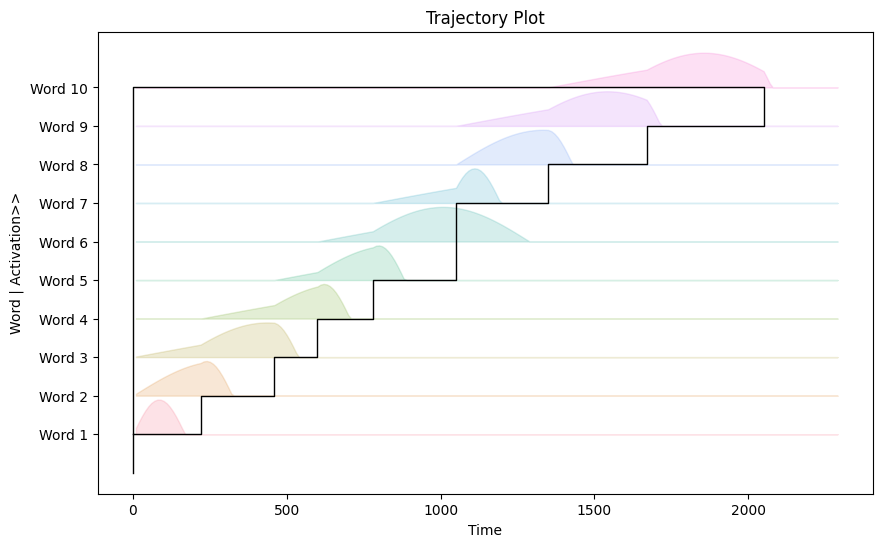

In [ ]:

# Dynamically select all columns that start with "Activation"
df_test = pd.DataFrame(sim["activations"])
activation_columns = df_test.columns[1:]

# Reshape the DataFrame to long format
df_long = df_test.melt(id_vars="Time", value_vars=activation_columns, 
                       var_name="Word", value_name="Value")

fixpos_df = pd.concat([
    pd.DataFrame(sim["trajectory"]),
    pd.DataFrame({
        "Time": [sim["trajectory"]["Time"].iloc[-1] + sim["trajectory"]["Duration"].iloc[-1]],
        "Fixation": [sim["trajectory"]["Fixation"].iloc[-1]],
        "Duration": [np.nan]
    })
])

# Plot trajectory
plt.figure(figsize=(10, 6))
for word in range(1, NW + 1):
    word_data = df_long[df_long["Word"] == word]
    plt.fill_between(
        word_data["Time"],
        word,
        word + 0.9 * word_data["Value"],
        color=sns.color_palette("husl", NW)[word - 1],
        alpha=0.2,
        label=f"Word {word}"
    )

plt.step(
    fixpos_df["Time"],
    fixpos_df["Fixation"],
    where="post",
    color="black",
    linewidth=1,
    label="Fixation"
)


#plt.gca().invert_yaxis()
plt.yticks(range(1, NW + 1), labels=[f"Word {i}" for i in range(1, NW + 1)])
plt.xlabel("Time")
plt.ylabel("Word | Activation>>")
plt.title("Trajectory Plot")
plt.show()

# Build model

## Trial

In [4]:
def prior():
    # decrease in processing span
    nu=np.random.gamma(shape=8, scale=0.03)
    # individual processing rate
    r=np.random.gamma(shape=18, scale=0.5)
    return dict(nu=nu, r=r)


# generate data for n trials
def likelihood(nu, r, n=114, max_saccades=20):
    trials = np.zeros((n, max_saccades, 4))
    (n,20,4)
    for i in range(n):
        trials[i,:,:] = toyswift(nu, r)
    # return data split by outcome variable ("time of saccade", "gaze fixation", "gaze duration", "real entry")
    return dict(time=np.expand_dims(trials[:,:,0], axis=-1), 
                fixation=np.expand_dims(trials[:,:,1], axis =-1),
                duration=np.expand_dims(trials[:,:,2], axis = -1),
                real=np.expand_dims(trials[:,:,3], axis = -1)
                )

# context
def _context():
    return dict(n = np.random.randint(10, 50))

def context(n=None):
    if n is None:
        n = 20 #np.random.randint(200, 351)
    return dict(n=n)

# sufficient statistics: mean, sd, n
def summary(rt):
    return dict(
        mean = np.mean(rt),
        sd = np.std(rt)
    )

simulator = bf.make_simulator([prior, likelihood]) # exclude context for now

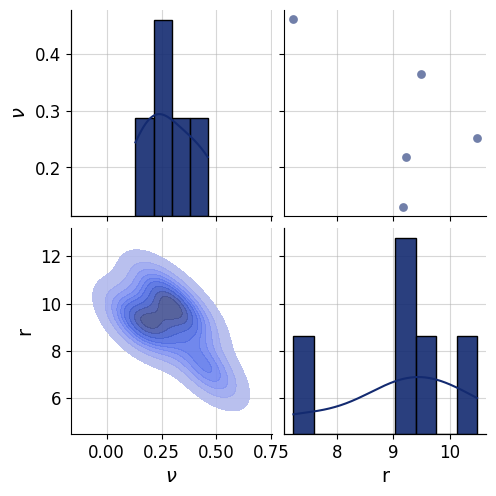

In [ ]:
f=bf.diagnostics.pairs_samples(
    df, 
    variable_keys=["nu", "r"],
    variable_names=[r"$\nu$", r"r"])

# Summary Network

In [6]:
adapter = (bf.Adapter()
    .constrain("nu", lower=0.)
    .constrain("r", lower = 0)
    .concatenate(["nu", "r"], into="inference_variables")
    # fixation.shape (batch_size, sentences, max_saccades, 1)
    .concatenate(["time", "fixation", "duration", 'real'], into="summary_variables")
    # summary_variables.shape (batch_size, sentences, max_saccades, 4)
    #.concatenate(['trials'], into='inference_conditions')
    )

In [7]:
class SequentialDeepSet(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.inner = keras.layers.TimeDistributed(
            bf.networks.TimeSeriesNetwork(bidirectional=False, recurrent_dim=64, summary_dim = 8)
        )
        self.outer = bf.networks.DeepSet()
    
    def call(self, x, training=False):
        x = self.inner(x, training=training)
        x = self.outer(x, training=training)
        return x
    
summary_network = SequentialDeepSet()

In [ ]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    summary_network=summary_network,
    
    inference_network = bf.networks.CouplingFlow(permutation="swap", subnet_kwargs=dict(dropout=False)),

    inference_variables = ["nu", "r"],
    #inference_conditions = ["trials"]
)

In [10]:
train_data = simulator.sample(2000)
validation_data = simulator.sample(200)

In [11]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=100, 
    batch_size=50, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 8.0995 - loss/inference_loss: 8.0995 - val_loss: 2.5050 - val_loss/inference_loss: 2.5050
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 2.3080 - loss/inference_loss: 2.3080 - val_loss: 2.0656 - val_loss/inference_loss: 2.0656
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 1.9809 - loss/inference_loss: 1.9809 - val_loss: 1.9456 - val_loss/inference_loss: 1.9456
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 1.7881 - loss/inference_loss: 1.7881 - val_loss: 1.1235 - val_loss/inference_loss: 1.1235
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 1.3203 - loss/inference_loss: 1.3203 - val_loss: 0.9339 - val_loss/inference_loss: 0.9339
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 1.2139 - loss/inference_loss: 1.2139 - val_loss: 0.7999 - val_loss/inference_loss: 0.7999
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 1.0333 - loss/inference_loss: 1.0333 - val_los

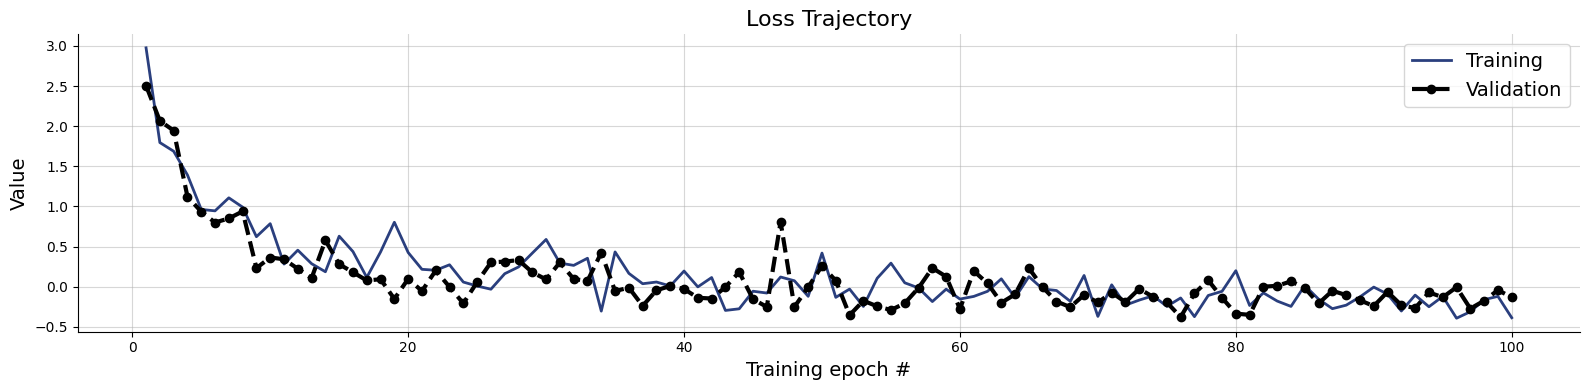

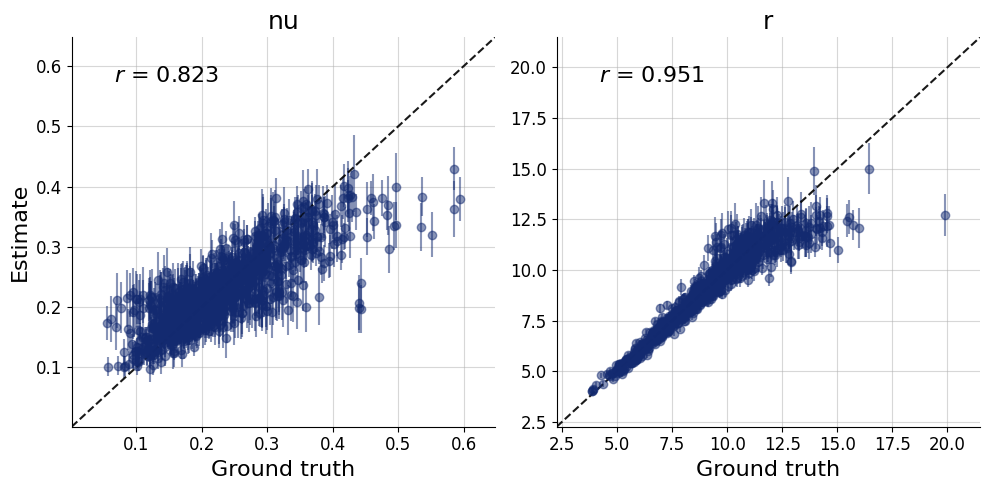

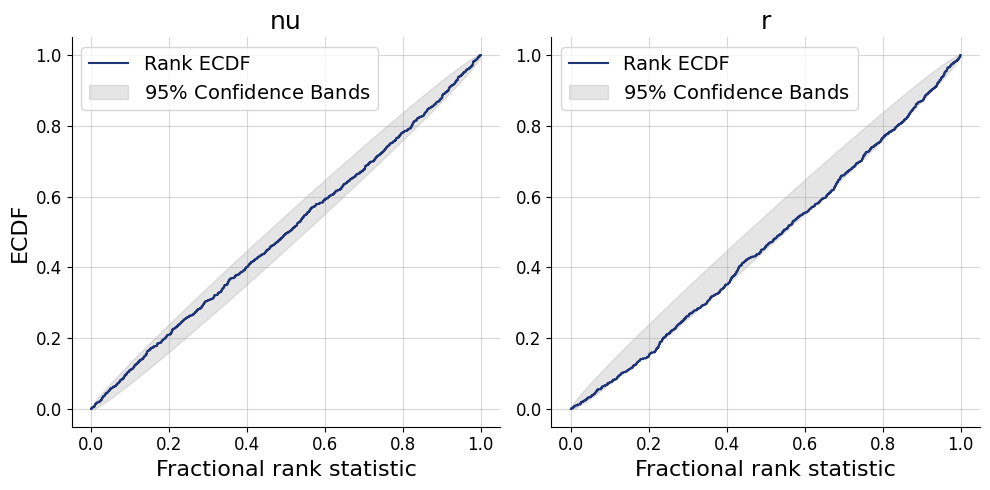

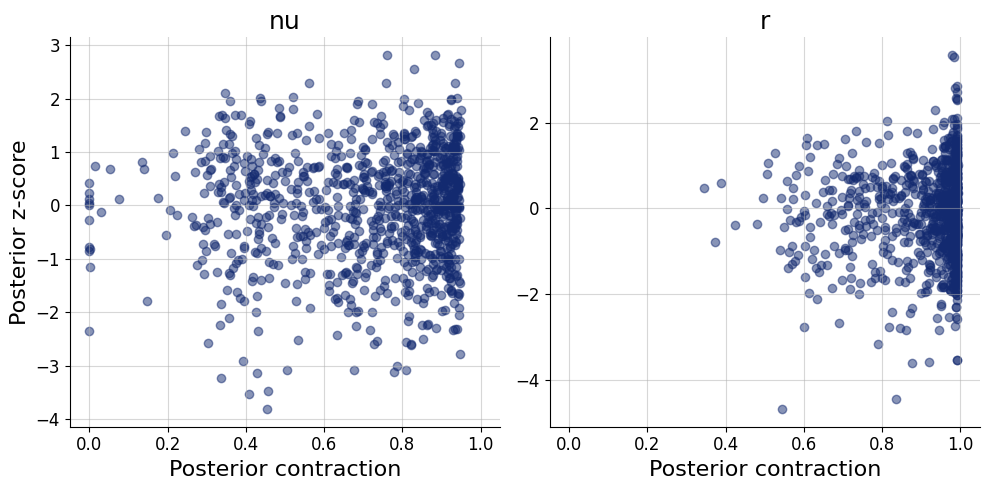

In [13]:
test_data = simulator.sample(1_000)
plots=workflow.plot_default_diagnostics(test_data=test_data)

In [16]:
os.getcwd() # '/Users/olejurgensen/Desktop/Lake Balaton Seminar/swift-flow'
os.chdir('/Users/olejurgensen/Desktop/Lake Balaton Seminar')

In [19]:
subject10_dat=pd.read_csv("fixseqin_PB2expVP10.dat",
     delimiter="\t",
     names=["sentID", "wordID", "duration"],
     usecols=[0, 1, 3])
subject10_dat.head()

,sentID,wordID,duration
0,1,1,183
1,1,3,165
2,1,3,115
3,1,4,210
4,1,6,266
